# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

### Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t', decimal=',')
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   total_images          23699 non-null  int64 
 1   last_price            23699 non-null  object
 2   total_area            23699 non-null  object
 3   first_day_exposition  23699 non-null  object
 4   rooms                 23699 non-null  int64 
 5   ceiling_height        14504 non-null  object
 6   floors_total          23613 non-null  object
 7   living_area           21796 non-null  object
 8   floor                 23699 non-null  int64 
 9   is_apartment          2775 non-null   object
 10  studio                23699 non-null  bool  
 11  open_plan             23699 non-null  bool  
 12  kitchen_area          21421 non-null  object
 13  balcony               12180 non-null  object
 14  locality_name         23650 non-null  object
 15  airports_nearest      18157 non-null

Анализ показа что есть много столбцов которые надо перевести в числовое значение. также надо заполнить пустые строки где это возможно.

total_images                     int64
last_price                     float64
total_area                     float64
first_day_exposition    datetime64[ns]
rooms                            int64
ceiling_height                 float64
floors_total                   float64
living_area                    float64
floor                            int64
is_apartment                      bool
studio                            bool
open_plan                         bool
kitchen_area                   float64
balcony                        float64
locality_name                   object
airports_nearest               float64
cityCenters_nearest            float64
parks_around3000               float64
parks_nearest                  float64
ponds_around3000               float64
ponds_nearest                  float64
days_exposition                float64
dtype: object


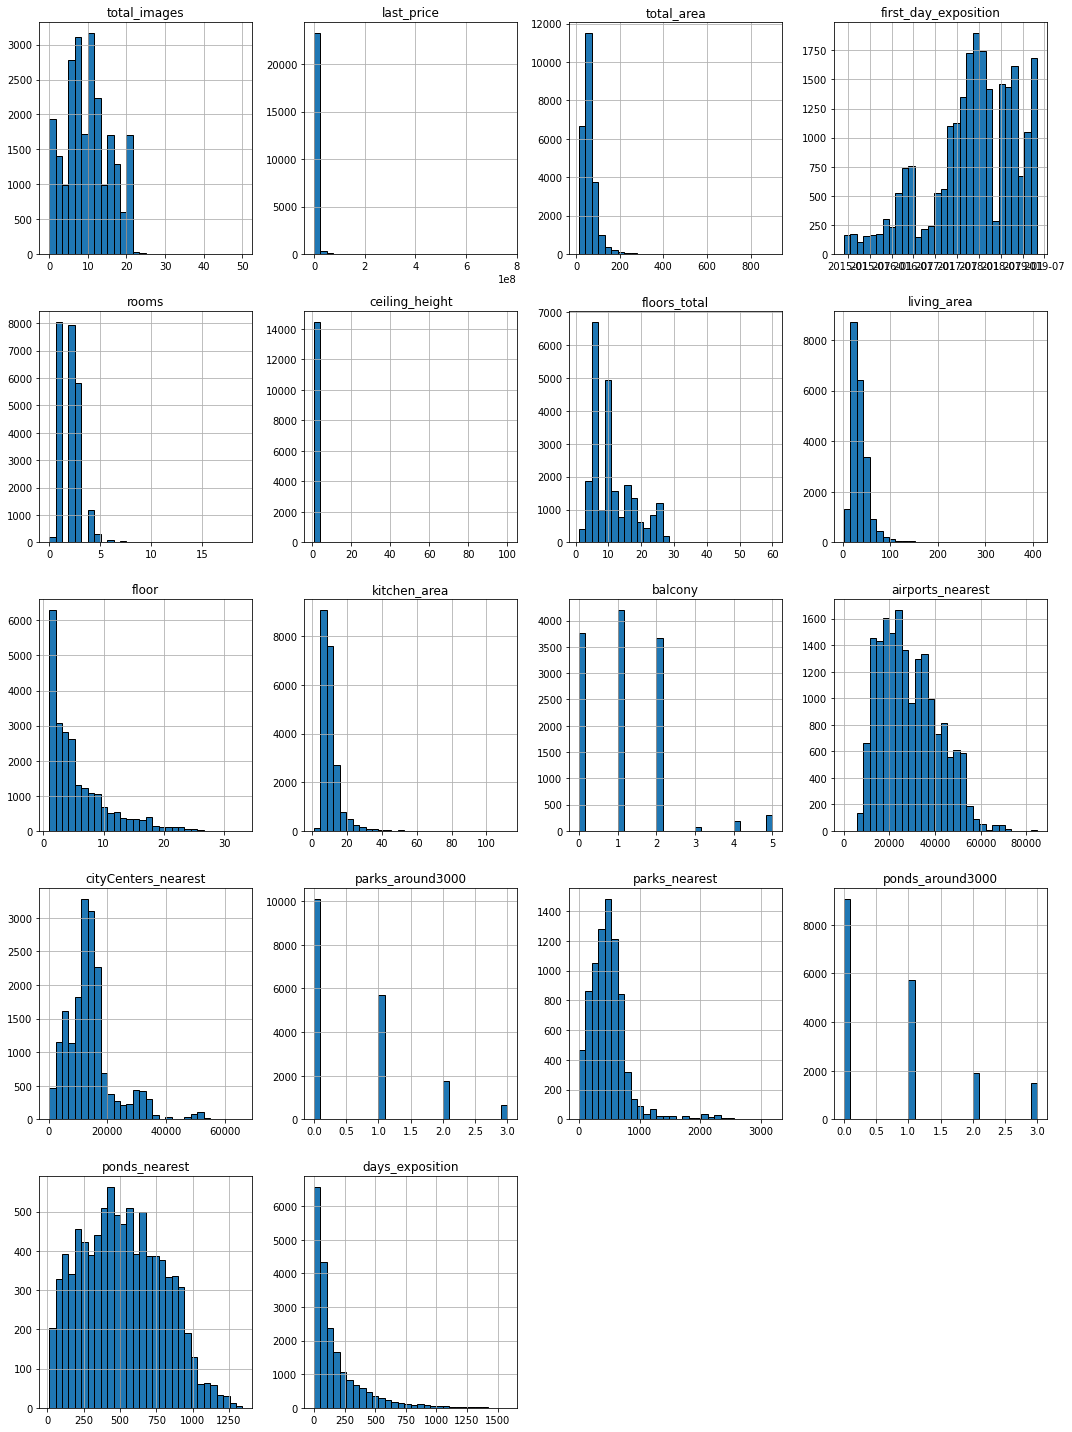

In [3]:
numeric_columns = [
    'last_price', 
    'total_area', 
    'ceiling_height', 
    'floors_total', 
    'living_area', 
    'kitchen_area', 
    'balcony', 
    'airports_nearest', 
    'cityCenters_nearest', 
    'parks_around3000', 
    'parks_nearest', 
    'ponds_around3000', 
    'ponds_nearest',
    'days_exposition'
]

for column in numeric_columns:
    data[column] = pd.to_numeric(data[column], errors='coerce')

data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], errors='coerce')
data['is_apartment'] = data['is_apartment'].map({'yes': True, 'no': False})
data['is_apartment'] = data['is_apartment'].fillna(False) 
print(data.dtypes)

data.hist(figsize=(15, 20), bins=30, edgecolor='black')
plt.tight_layout()
plt.show()

Были исправлены форматы столбцов (14) из строковых они были переведы в числовые, для удобства проведения математических расчетов, также без числовых значения не получилось бы вывести гистограммы и провести визуальный анализ сырых данных.
Столбец "first_day_exposition" — дата публикации, был переведен в формат даты для удобства проведения анализа.
Столбец "is_apartment" - имеет много пропусков которые по логике должны быть переведены в булев массив, если встречается пустое значение оно заполняется False.

### Выполните предобработку данных

In [4]:
missing_values = data.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
missing_values

parks_nearest          15620
ponds_nearest          14589
balcony                11519
ceiling_height          9195
airports_nearest        5542
cityCenters_nearest     5519
parks_around3000        5518
ponds_around3000        5518
days_exposition         3181
kitchen_area            2278
living_area             1903
floors_total              86
locality_name             49
dtype: int64

Столбец "balcony" имеет большое количество пропусков - 48.6%, по всей видимости там где нет записей значение будет равно - 0, что было и сделано в коде ниже.
Столбец "floors_total" - незначительное количество пропусков по всей видимости это одноэтажные здания, поэтому были заполнены единицами.

Столбцы ['ceiling_height', 'living_area', 'kitchen_area', 'cityCenters_nearest','parks_nearest', 'ponds_nearest', airports_nearest] - были заполнены медианными значениями, там где имеются пропуска.
Столбец "locality_name" - имел незначительное количество пропусков и поэтому пустые строки были записаны как "unknown", незначительность пропусков не повлияет на конечный результат.

В столбцах "parks_around3000" и "ponds_around3000" - информация о наличии парков и прудов в радиусе 3 км, пустые значение решено заполнить нулями. 


In [5]:
data['balcony'] = data['balcony'].fillna(0)#
data['floors_total'] = data['floors_total'].fillna(1)#

data['rooms'] = data['rooms'].replace(0, 1)
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())

data['locality_name'] = data['locality_name'].fillna(value='unknown')


def fill_kitchen_area(df):
    condition = df['kitchen_area'].isna() & df['living_area'].notna() & df['rooms'].notna()
    df.loc[condition, 'kitchen_area'] = df.loc[condition, 'living_area'] / df.loc[condition, 'rooms']
    return df

data = fill_kitchen_area(data)

def fill_living_area(df):
    condition = df['living_area'].isna() & df['total_area'].notna()
    df.loc[condition, 'living_area'] = df.loc[condition, 'total_area']
    return df

data = fill_living_area(data)

In [6]:
data[data['ponds_nearest'].isna()]['ponds_around3000'].value_counts()

0.0    9071
Name: ponds_around3000, dtype: int64

In [7]:
missing_values = data.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
missing_values

parks_nearest          15620
ponds_nearest          14589
airports_nearest        5542
cityCenters_nearest     5519
parks_around3000        5518
ponds_around3000        5518
days_exposition         3181
kitchen_area            1464
dtype: int64

In [8]:
unique_names = data['locality_name'].unique()
print("Было:", len(data['locality_name'].unique()))


Было: 365


In [9]:
data['locality_name'] = (
    data['locality_name']
    .str.replace('ё', 'е')
    .replace(['что заменять', 'что ещё заменять', ...], 'на что заменять', regex=True)
) 

In [10]:
def clean_locality(name):
    if pd.isna(name):
        return name
    name = name.lower()
    name = re.sub(r'пос[её]лок( городского типа)?', 'поселок', name)
    name = re.sub(r'городской поселок', 'поселок', name)
    name = re.sub(r'садовое товарищество', 'ст', name)
    name = re.sub(r'\s+', ' ', name)
    return name.strip().capitalize()

data['locality_cleaned'] = data['locality_name'].apply(clean_locality)

print(f"До очистки: {data['locality_name'].nunique()} уникальных значений")
print(f"После очистки: {data['locality_cleaned'].nunique()} уникальных значений")
print(data[['locality_name', 'locality_cleaned']].drop_duplicates().head(20))

До очистки: 331 уникальных значений
После очистки: 323 уникальных значений
                          locality_name         locality_cleaned
0                       Санкт-Петербург          Санкт-петербург
1                        поселок Шушары           Поселок шушары
5             городской поселок Янино-1          Поселок янино-1
6                     поселок Парголово        Поселок парголово
8                        поселок Мурино           Поселок мурино
11                            Ломоносов                Ломоносов
12                            Сертолово                Сертолово
13                             Петергоф                 Петергоф
14                               Пушкин                   Пушкин
22                      деревня Кудрово          Деревня кудрово
30                             Коммунар                 Коммунар
33                              Колпино                  Колпино
37  поселок городского типа Красный Бор      Поселок красный бор
47             

Проведена ревизия столбцов где имелись пропуска. В итоге были переботаны строки кода отвечающие за заполнения пропусков. 
К примеру в квартирах студиях где нет отдельной кухни, пропуска были сохранены (1464 значения). 
Значение "living_area" жилая площадь была заполнена из столбца "total_area" общая площадь. 
Столбец days_exposition с пропусками был сохранен, так как объявления по всей видимости были все еще активны.

Создана функция предназначеная для очистки данных от неявных дубликатов, к примеру "поселок городского типа" заменен на "поселок", также был применен нижный регистр в случае если данные были заполнены строковыми значениями.
Было выявлено 8 неявных дубликатов которые могли исказить результаты.

### Добавьте в таблицу новые столбцы

In [11]:
data['price_per_square_meters'] = (data['last_price'] / data['total_area']).round()

# Проверим первые 10 значений
print(data['price_per_square_meters'].head(10))


0    120370.0
1     82921.0
2     92786.0
3    408176.0
4    100000.0
5     95066.0
6     99196.0
7    110545.0
8     87455.0
9     88525.0
Name: price_per_square_meters, dtype: float64


Путем деления значения столбца "последняя цена" на "общую площадь" мы получили цену за кв.метр, эти данные были записаны в новый столбец "цена за кв.метр".

In [12]:
data['weekday_exposition'] = data['first_day_exposition'].dt.weekday
print(data[['first_day_exposition', 'weekday_exposition']].head(10))

  first_day_exposition  weekday_exposition
0           2019-03-07                   3
1           2018-12-04                   1
2           2015-08-20                   3
3           2015-07-24                   4
4           2018-06-19                   1
5           2018-09-10                   0
6           2017-11-02                   3
7           2019-04-18                   3
8           2018-05-23                   2
9           2017-02-26                   6


Добавлен столбец день публикации объявления.

In [13]:
data['month_exposition'] = data['first_day_exposition'].dt.month
print(data[['first_day_exposition', 'month_exposition']].head(10))

  first_day_exposition  month_exposition
0           2019-03-07                 3
1           2018-12-04                12
2           2015-08-20                 8
3           2015-07-24                 7
4           2018-06-19                 6
5           2018-09-10                 9
6           2017-11-02                11
7           2019-04-18                 4
8           2018-05-23                 5
9           2017-02-26                 2


Добавлен столбец месяц публикации объявления.

In [14]:
data['year_exposition'] = data['first_day_exposition'].dt.year
print(data[['first_day_exposition', 'year_exposition']].head(10))

  first_day_exposition  year_exposition
0           2019-03-07             2019
1           2018-12-04             2018
2           2015-08-20             2015
3           2015-07-24             2015
4           2018-06-19             2018
5           2018-09-10             2018
6           2017-11-02             2017
7           2019-04-18             2019
8           2018-05-23             2018
9           2017-02-26             2017


Добавлен столбец год публикации объявления.

In [15]:
def get_floor_type(row):
    if pd.isna(row['floor']) or pd.isna(row['floors_total']):
        return None
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'

data['floor_type'] = data.apply(get_floor_type, axis=1)
print(data[['floor', 'floors_total', 'floor_type']].head(20))

    floor  floors_total floor_type
0       8          16.0     другой
1       1          11.0     первый
2       4           5.0     другой
3       9          14.0     другой
4      13          14.0     другой
5       5          12.0     другой
6       6          26.0     другой
7      22          24.0     другой
8      26          27.0     другой
9       7           9.0     другой
10      3          12.0     другой
11      4           5.0     другой
12      5           5.0  последний
13      5           5.0  последний
14      1           6.0     первый
15      5          14.0     другой
16      1           5.0     первый
17      7          17.0     другой
18      2           5.0     другой
19      8          16.0     другой


In [16]:
data['cityCenter_in_kilometers'] = (data['cityCenters_nearest'] / 1000).round()
print(data['cityCenter_in_kilometers'].head(10))

0    16.0
1    19.0
2    14.0
3     7.0
4     8.0
5     NaN
6    19.0
7    12.0
8     NaN
9    15.0
Name: cityCenter_in_kilometers, dtype: float64


Данный код добавляет столбец рассторяние от центра города в километрах.

### Проведите исследовательский анализ данных

In [17]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.22)
    Q3 = df[column].quantile(0.78)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

data = remove_outliers_iqr(data, 'total_area')
data = remove_outliers_iqr(data, 'last_price')

data = remove_outliers_iqr(data, 'rooms')
data = remove_outliers_iqr(data, 'balcony')


def replace_below_threshold_with_nan(data, column, threshold):
    data.copy()
    data['last_price'] = data['last_price'].apply(lambda x: np.nan if x < threshold else x)
    return data
threshold = 3_000_000
data = replace_below_threshold_with_nan(data, 'last_price', threshold)

   area_category  Количество объявлений
0       30-50 м²                  11118
1       50-75 м²                   7517
2      75-200 м²                   2534
3  вне диапазона                     27


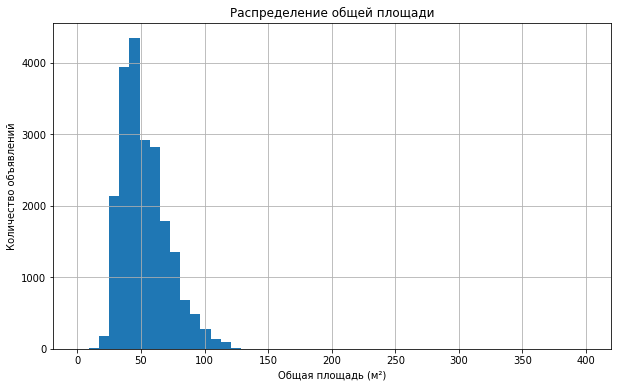

In [18]:
def categorize_area(row):
    if 20 <= row <= 50:
        return '30-50 м²'
    elif 50 < row <= 75:
        return '50-75 м²'
    elif 75 < row <= 200:
        return '75-200 м²'
    else:
        return 'вне диапазона'
    
data['area_category'] = data['total_area'].apply(categorize_area)   
pivot_table = data.pivot_table(
    index='area_category',
    values='total_area',
    aggfunc='count'
).rename(columns={'total_area': 'Количество объявлений'}).reset_index()

print(pivot_table)

data['total_area'].hist(bins=50, range=(1,400), figsize=(10, 6))
plt.title('Распределение общей площади')
plt.xlabel('Общая площадь (м²)')
plt.ylabel('Количество объявлений')
plt.grid(True)
plt.show()

Данная гистограмма отчетливо показывает соотношения объявлений по общей площади. Отчетливо видно что самые многочисленные объявления начинаются с 30 до 50 кв.метров, значения превышает 11 тыс объявлений. Возможно данная цифра сведетельствует о большом количестве  типовых однокомнатных или популярности данного формата.
Также заметно что объявления о продаже квартир площадью от 50 до 75 кв.метров в целом не сильно отстают 7.5 тыс объявлений. Жилье площадью от 75 до 200 кв.метров наименее популярны и достигают 2.5 тыс показов.

  living_area_category  Количество объявлений
0             10-45 м²                  17612
1             46-75 м²                   3137
2            76-200 м²                    255
3        вне диапазона                    192


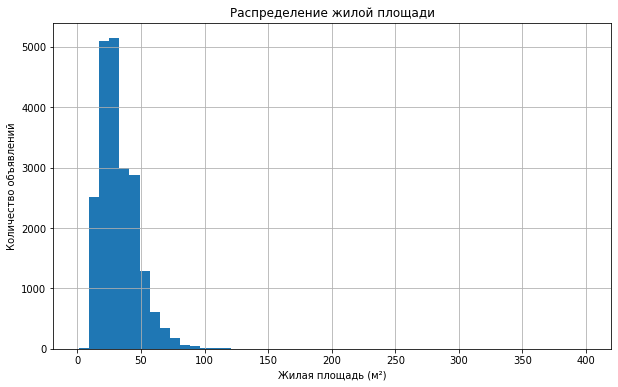

In [19]:
def categorize_area(row):
    if 10 <= row <= 45:
        return '10-45 м²'
    elif 46 <= row <= 75:
        return '46-75 м²'
    elif 76 <= row <= 200:
        return '76-200 м²'
    else:
        return 'вне диапазона'
    
data['living_area_category'] = data['living_area'].apply(categorize_area)  

pivot_table = data.pivot_table(
    index='living_area_category',
    values='living_area',
    aggfunc='count'
).rename(columns={'living_area': 'Количество объявлений'}).reset_index()

print(pivot_table)

data['living_area'].hist(bins=50, range=(1,400), figsize=(10, 6))
plt.title('Распределение жилой площади')
plt.xlabel('Жилая площадь (м²)')
plt.ylabel('Количество объявлений')
plt.grid(True)
plt.show()

Структура объявлений по критерию "жилая площадь" показала примерно одинаковый паттерн как и общая площадь. Видно знательное доминирование маленьких квартир. То есть имеется отрицательная корреляция площади жилья и количества объявлений.

  kitchen_area_category  Количество объявлений
0                1-7 м²                   5405
1              16-25 м²                   1334
2               8-15 м²                  11660
3         вне диапазона                   1486


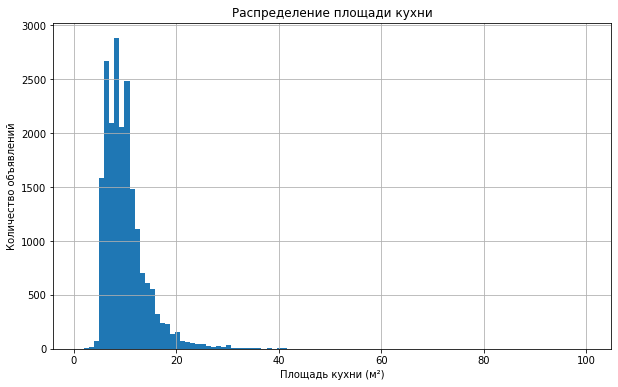

In [20]:
def categorize_area(row):
    if 1 <= row <= 7:
        return '1-7 м²'
    elif 8 <= row <= 15:
        return '8-15 м²'
    elif 16 <= row <= 25:
        return '16-25 м²'
    else:
        return 'вне диапазона'
    
data['kitchen_area_category'] = data['kitchen_area'].apply(categorize_area)  

pivot_table = data.pivot_table(
    index='kitchen_area_category',
    values='kitchen_area',
    aggfunc='count'
).rename(columns={'kitchen_area': 'Количество объявлений'}).reset_index()

print(pivot_table)


data['kitchen_area'].hist(bins=100, range=(1,100),figsize=(10, 6))
plt.title('Распределение площади кухни')
plt.xlabel('Площадь кухни (м²)')
plt.ylabel('Количество объявлений')
plt.grid(True)
plt.show()

В целом анализ показа что большинтсво продаваемых квартир имеют площадь кухни от 8 до 15 кв.метров. На втором месте квартиры с очень маленькими площадями кухонь до 7 кв.метров. Площадь кухонь до 25 кв. метров встречаются довольно редко. 

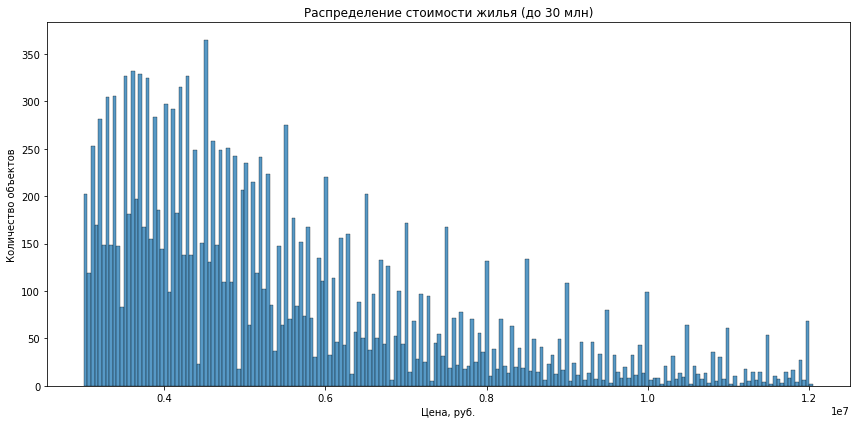

In [21]:
filtered_data = data[data['last_price'] <= 30_000_000]

plt.figure(figsize=(12, 6))
sns.histplot(filtered_data['last_price'], bins=200,)

plt.title('Распределение стоимости жилья (до 30 млн)')
plt.xlabel('Цена, руб.')
plt.ylabel('Количество объектов')

plt.tight_layout()
plt.show()

Анализ данных по ценовому распределению квартир в Санкт-Петербурге показал что значительная доля продаваемого жилья находятся в диапазоне от 2.5 до 6 млн рублей.

  rooms_category  Количество объявлений
0  1-2 комнатные                  15633
1  3-4 комнатные                   5468
2  5-9 комнатные                     95


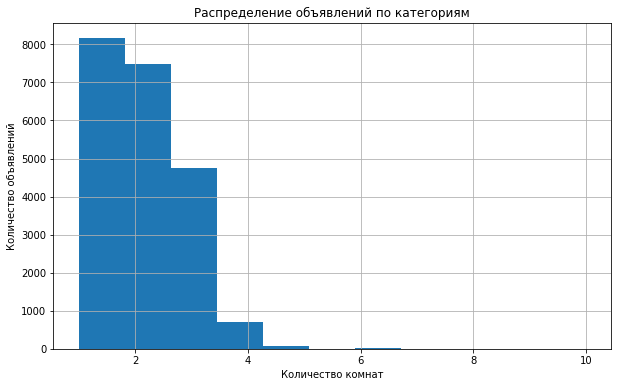

In [22]:
def categorize_area(row):    
    if 1 <= row <= 2:
        return '1-2 комнатные'
    elif 3 <= row <= 4:
        return '3-4 комнатные'
    elif 5 <= row <= 9:
        return '5-9 комнатные'
    else:
        return 'вне диапазона'
    
data['rooms_category'] = data['rooms'].apply(categorize_area)  

pivot_table = data.pivot_table(
    index='rooms_category',
    values='rooms',
    aggfunc='count'
).rename(columns={'rooms': 'Количество объявлений'}).reset_index()

print(pivot_table)

data['rooms'].hist(bins=11, range=(1,10), figsize=(10, 6))
plt.title('Распределение объявлений по категориям')
plt.xlabel('Количество комнат')
plt.ylabel('Количество объявлений')
plt.grid(True)
plt.show()

Анализ рынка жилья хорошо показывает что самыми популярными являются одно-двух комнатные квартиры 16 тыс позиций, далее идут трех-четырех комнатные квартиры.

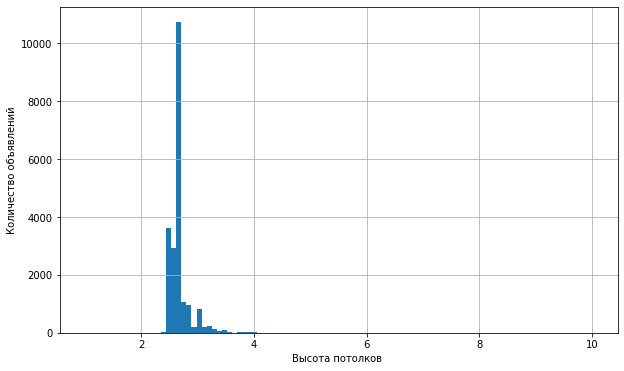

In [23]:
data.loc[data['ceiling_height'] > 10, 'ceiling_height'] = data['ceiling_height'] / 10
data['ceiling_height'].hist(bins=100, range=(1,10), figsize=(10, 6))
plt.xlabel('Высота потолков ')
plt.ylabel('Количество объявлений')
plt.grid(True)
plt.show()

Перед визуализацией данных о высоте потолков были учтены ошибки в высоте, когда вместо 3.2 было внесено 32 и т.п. Большая часть квартир имеет высоту 2.3 метра.

                    floor_type_encoded  last_price
floor_type_encoded            1.000000    0.045534
last_price                    0.045534    1.000000

первый        2780
другой       15483
последний     2933
Name: floor_type, dtype: int64


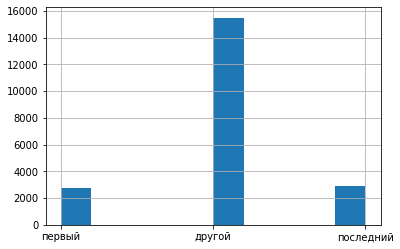

In [24]:
data['floor_type'].hist()

floor_type_map = {
    'первый': 0,
    'другой': 1,
    'последний': 2
}

data['floor_type_encoded'] = data['floor_type'].map(floor_type_map)

correlation = data[['floor_type_encoded', 'last_price']].corr()
print(correlation)
print()

print(data['floor_type'].value_counts().reindex(['первый', 'другой', 'последний']))

Было очевидно что в объявлениях о продажах в многоэтажных домах будет преобладать не первый и не последний этаж. Не было выявлено корреляции между этажность и стоимостью цены. В объявлениях преобладали в основном "средние" этажи.  

5.0     5354
9.0     3582
12.0    1246
16.0    1210
10.0    1036
4.0      993
25.0     963
17.0     764
6.0      654
3.0      599
Name: floors_total, dtype: int64


Text(0.5, 1.0, 'Показатели этажности зданий')

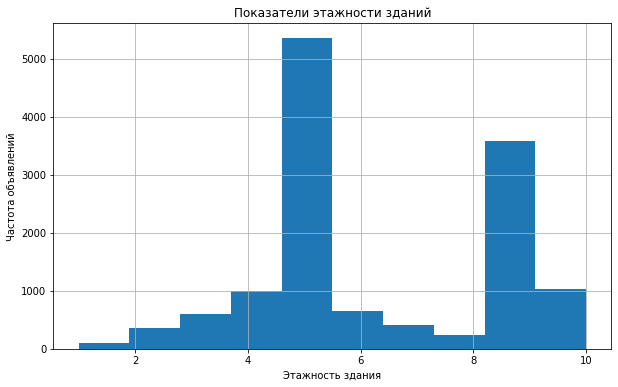

In [25]:
data['floors_total'].hist(bins=10, range=(1,10), figsize=(10, 6))
print(data['floors_total'].value_counts(ascending=False).head(10))
plt.ylabel('Частота объявлений')
plt.xlabel('Этажность здания')
plt.title('Показатели этажности зданий')

Замечено большое количество объявлений самых популярных типов домов "пятиэтажках", тем не менее не редки продажи и в девяти и более этажных домах.

                     cityCenters_nearest  last_price
cityCenters_nearest             1.000000   -0.321961
last_price                     -0.321961    1.000000


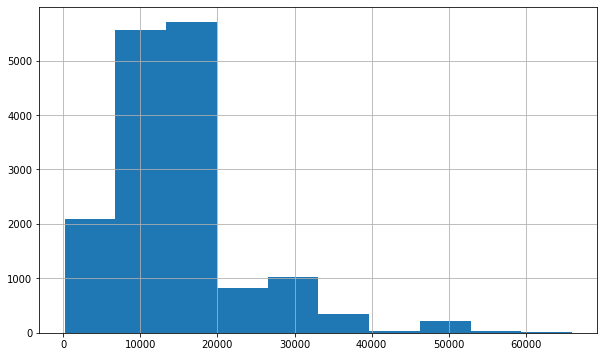

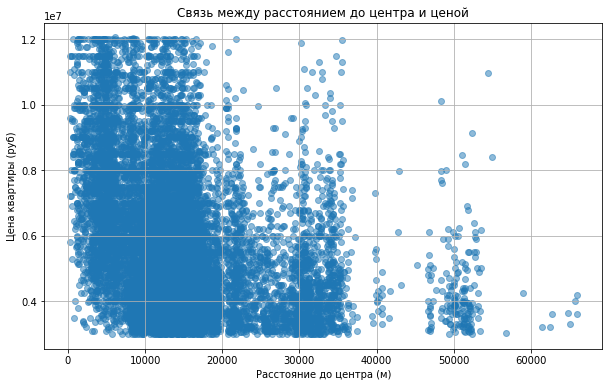

In [26]:
data['cityCenters_nearest'].hist(figsize=(10, 6))

correlation = data[['cityCenters_nearest', 'last_price']].corr()
print(correlation)

plt.figure(figsize=(10, 6))
plt.scatter(data['cityCenters_nearest'], data['last_price'], alpha=0.5)
plt.xlabel('Расстояние до центра (м)')
plt.ylabel('Цена квартиры (руб)')
plt.title('Связь между расстоянием до центра и ценой')
plt.grid(True)
plt.show()

Выявлена отрицательная корреляция между ценой и близостью центра города. Америку мы этим не открыли, но для отчетности стоит это упомянуть. Также замечено что жилье в СПб в целом крайне редко ниже 2 млн рублей. 

               parks_nearest  last_price
parks_nearest        1.00000     0.03896
last_price           0.03896     1.00000


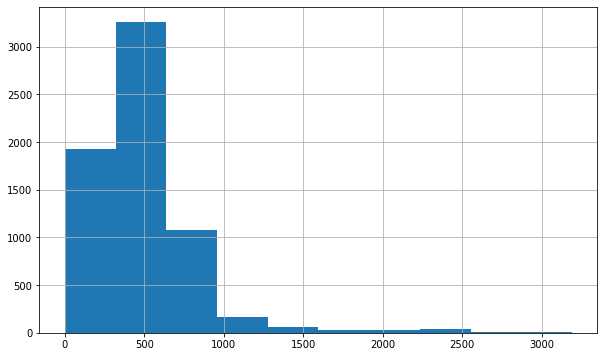

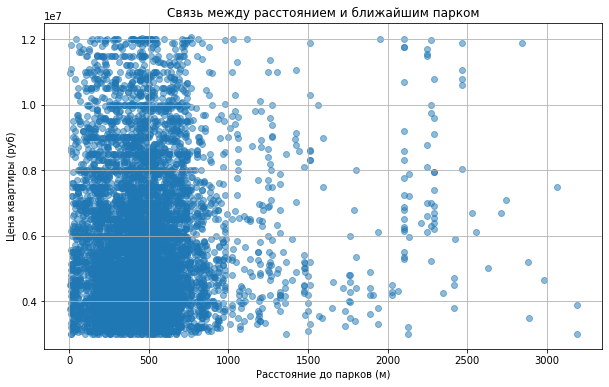

In [27]:
data['parks_nearest'].hist(figsize=(10, 6))

subset = data[['parks_nearest', 'last_price']].dropna()

correlation = data[['parks_nearest', 'last_price']].corr()
print(correlation)

plt.figure(figsize=(10, 6))
plt.scatter(subset['parks_nearest'], subset['last_price'], alpha=0.5)
plt.xlabel('Расстояние до парков (м)')
plt.ylabel('Цена квартиры (руб)')
plt.title('Связь между расстоянием и ближайшим парком')
plt.grid(True)
plt.show()

Питер город парков и я там был, могу подтвердить, если не верите взгляните в любой навигатор. Большинство объявлений указывают на то что квартиры находятся на небольшом расстоянии от парков.

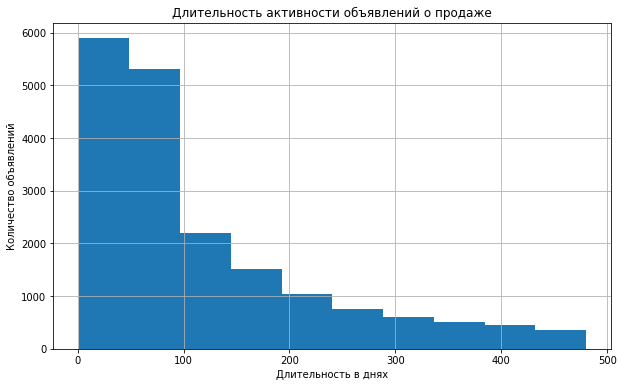

Корреляция между длительностью объявлений и этажом: -0.031
count    18634.000000
mean       118.939304
std        109.615957
min          1.000000
25%         43.000000
50%         91.000000
75%        161.000000
max        480.000000
Name: days_exposition, dtype: float64


In [28]:
Q1 = data['days_exposition'].quantile(0.25)
Q3 = data['days_exposition'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

median = data['days_exposition'].median()

data['days_exposition'] = data['days_exposition'].apply(lambda x: median if x < lower_bound or x > upper_bound else x)


data['days_exposition'].hist(figsize=(10, 6))
plt.xlabel('Длительность в днях')
plt.ylabel('Количество объявлений')
plt.title('Длительность активности объявлений о продаже')
plt.grid(True)
plt.show()

correlation = data['days_exposition'].corr(data['floor_type_encoded'])

print(f"Корреляция между длительностью объявлений и этажом: {correlation:.3f}")

print(data['days_exposition'].describe())


Анализ показал что объявления были активны в среднем 91 день. Медианное значение составило 118 дней. Быстрыми продажами можно назвать те что длились 43 дня, а долгими 161 день.

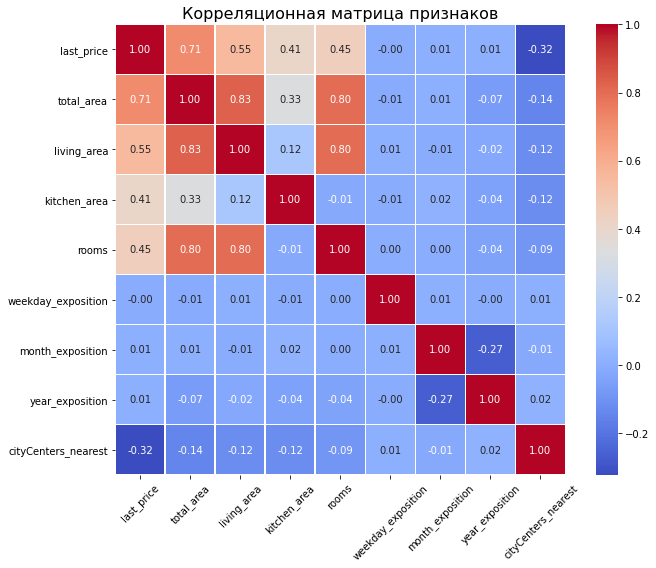

In [29]:
correlation = data[['last_price','total_area', 'living_area', 'kitchen_area', 'rooms', 'weekday_exposition', 'month_exposition', 'year_exposition', 'cityCenters_nearest']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, square=True)
plt.title("Корреляционная матрица признаков", fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Таблица показывает степень корреляции признаков. Чем краснее ячейка тем сильнее положительная корреляция, синие ячейки говорят об отрицательной корреляции. 
Анализируя таблицу видно что общая и жилая площадь в значительной степени влияют на цену также как и количество комнат.
Интересная корреляция замечена по размеру продаваемых квартир, чем ближе к центру, тем меньше площадь жилья.
День, месяц и год подачи объявления практически никак не влияют на какие либо показатели.

In [30]:
data['pricing_per_meters'] = round(data['last_price'] / data['total_area'])

pivot_table = (
    data
    .groupby('locality_name')
    .agg(
        ads_count=('locality_name', 'count'),
        avg_price_per_sq_m=('pricing_per_meters', 'mean')
    )
    .sort_values(by='ads_count', ascending=False)
    .head(10)
)

print(pivot_table)


                   ads_count  avg_price_per_sq_m
locality_name                                   
Санкт-Петербург        13493       106351.935506
поселок Мурино           542        87037.062500
поселок Шушары           429        79482.606838
Всеволожск               379        68721.094650
Пушкин                   329       100926.086538
поселок Парголово        326        91934.816667
Колпино                  325        75006.040650
Гатчина                  293        72523.371795
деревня Кудрово          293        92773.100418
Выборг                   230        62399.854369


Предоставленная сводная таблица хорошо показывает что большинство объявлений приходиться на сам город Санкт-Петербург, там же отмечена самая высокая средняя стоимость жилья (105 тыс руб за метр). На втором месте по стоимости жилья населенный пункт Пушкин (100 тыс за метр). Самая низкая стоимость жилья в Выборге (58 тыс за метр).

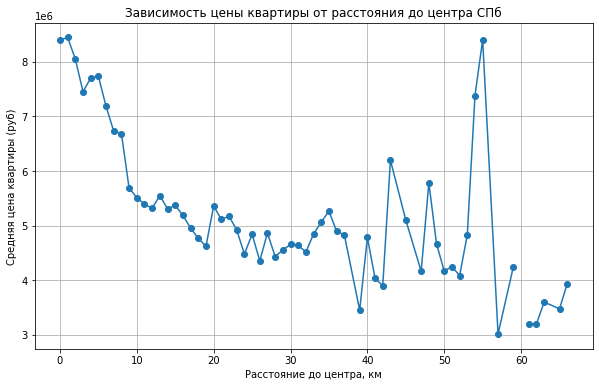

In [31]:
#spb_data = data[data['locality_name'] == 'Санкт-Петербург'].copy()

data['cityCenters_nearest_km'] = (data['cityCenters_nearest'] / 1000).round()

km_price = data.groupby('cityCenters_nearest_km')['last_price'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(km_price['cityCenters_nearest_km'], km_price['last_price'], marker='o')
plt.title('Зависимость цены квартиры от расстояния до центра СПб')
plt.xlabel('Расстояние до центра, км')
plt.ylabel('Средняя цена квартиры (руб)')
plt.grid(True)
plt.show()


Ближе к центру города цена значительно увеличивается. Заметно что цены стабилизируются если расстояние составляет от 10 км и более. Небольшие пики возможно связаны с городами вокруг СПб. 

### Напишите общий вывод
* Предоставленный датасет отлично описывает особенности рынка жилья в городе Санкт-Петербург и ближайших населенных пунктах. Предварительно была проведена обработка пропусков с заменой на медиану, и удаление аномальных значений для более точного анализа средних значений. Также перед анализом был проведен перевод строковых значений в числовой, там где это требовалось. Столбец дата был переведен в соответствующий формат. Была проведена оптимизация стоблца населенные пункты (locality_name) с целью удаления неявных дубликатов в названиях.

* Были добавлены столбцы: цена за кв.метр, день,месяц, год публикации объявления. Была проведена группировка данных по критерию этажа. 

* Была проведена группировка данных по жилой площади и по общей площади, также по площади кухни, данные были разделены на 4 группы по возрастанию. Была выведена гистограмма показывающая отчетливое преобладание маленьких однокомнатных квартир на рынке жилья 

* Был проведен анализ данных по ценообразованию, выявлено что большинство объявлений находятся в диапазоне 2.5 до 7.5 млн рублей. Большинство объявлений это 1-2 комнатные дома и квартиры. Высота потомков в большинстве своем составляет 2.3 метра и не сильно варируется.

* Была выявлена слабая корреляция между этажом продаваемого жилья и стоимостью, то есть этаж не влияет как либо на конечную стоимость квартиры. Также был установлено что большинство объявлений о продажи квартир это пяти (5.7 тыс) и девяти этажные дома (3.7 тыс), значительно реже шестьнадцати (1.2 тыс) и двенадцати этажные здания (1.3 тыс).

* Установлено что квартиры начинают дорожають ближе к центру, отрицательная корреляция составляет 19%. В тоже время установлено что близость парков никак не вляет на стоимость жилья, так как в среднем парки находятся на расстоянии менее 1 км. 

* Была сформирована корреляционная матрица по основным признакам: цена, общая площадь, жилая площадь, площадь кухни, кол-во комнат, день, месяц, год подачи объявления, и близость к центру города. Матрица показала что на стоимость жилья влияет жилая и общая площадь, количество комнат и площадь кухни. Установлено что ближе к центру квартиры начинают уменьшаться, а стоимость возрастать.

* Дата публикации объявлений имеет слабую взаимосвязь со стоимостью, то есть нет сезонности которая могла бы как то повлиять на цены.

* Была установлена средняя стоимость 1 кв.метра в 10 самых популярных населенных пунктах. Самая высокая цена была в самом Санкт-Петербурге (105 тыс руб) и селе Пушкин (100 тыс руб). 

* **Итог** Предоставленный отчет отлично описывает данные об особенностях рынка жилья в СПб, предоставленные данные могут пригодиться всем кто как либо вовлечен в рынке недвижимости. 


**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Файл с данными открыт.
- [ ]  Файл с данными изучен: выведены первые строки, использован метод `info()`, построены гистограммы.
- [ ]  Найдены пропущенные значения.
- [ ]  Пропущенные значения заполнены там, где это возможно.
- [ ]  Объяснено, какие пропущенные значения обнаружены.
- [ ]  В каждом столбце установлен корректный тип данных.
- [ ]  Объяснено, в каких столбцах изменён тип данных и почему.
- [ ]  Устранены неявные дубликаты в названиях населённых пунктов.
- [ ]  Обработаны редкие и выбивающиеся значения (аномалии).
- [ ]  В таблицу добавлены новые параметры:
       – цена одного квадратного метра;
       – день публикации объявления (0 - понедельник, 1 - вторник и т. д.);
       – месяц публикации объявления;
       – год публикации объявления;
       – тип этажа квартиры (значения — «первый», «последний», «другой»);
       – расстояние до центра города в километрах.
- [ ]  Изучены и описаны параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего парка.
- [ ]  Выполнено задание «Изучите, как быстро продавались квартиры (столбец `days_exposition`)»:
    - построена гистограмма;
    - рассчитаны среднее и медиана;
    - описано, сколько обычно занимает продажа и указано, какие продажи можно считать быстрыми, а какие — необычно долгими.
- [ ]  Выполнено задание «Определите факторы, которые больше всего влияют на общую (полную) стоимость объекта». Построены графики, которые показывают зависимость цены от параметров:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - количество комнат;
        - тип этажа, на котором расположена квартира (первый, последний, другой);
        - дата размещения (день недели, месяц, год).
- [ ]  Выполнено задание «Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений»:
    - выделены населённые пункты с самой высокой и низкой стоимостью квадратного метра.
- [ ]  Выполнено задание «Выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите их среднюю стоимость на разном удалении от центра»:
    -  учтён каждый километр расстояния, известны средние цены квартир в одном километре от центра, в двух и так далее;
    -  описано, как стоимость объекта зависит от расстояния до центра города;
    -  построен график изменения средней цены для каждого километра от центра Петербурга.
- [ ]  На каждом этапе сделаны промежуточные выводы.
- [ ]  В конце проекта сделан общий вывод.